# Step 4: Preprocessing & Feature Engineering

Load the final data from steps 2 & 3, create our target variable (and any other relevant features), then scale and prepare data for modelling.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [33]:
# Load final data
data = pd.read_csv('data/processed/data.csv')
data.head()

,Unnamed: 0,customer,invoice_date,qty_shipped,item,description,item_price,customer.1,industry,contact_owner,lifetime_sales,first_sale,county,market_opportunity,%_market_opp
0,0,1HOLPS,2015-05-08,1.0,T3000,MOTO MTR3000 BASE RADIO,6020.8,1HOLPS,K12 Education,Keith Johnson,39760.49,11/01/1999,Ottawa,825673.0,0.309
1,3,1VANAI,2015-04-17,2.0,AAM27QNH9LA1,XPR 4550 403-470 1-25W 160 CH,681.0,1VANAI,Healthcare,Skip Petrovich,25907.89,10/25/2004,Kent,1601574.0,0.421
2,4,1VANAI,2015-04-17,2.0,SEC1223MOTOTRBO,SAMLEX BASE STATION PWR SUPPLY,156.0,1VANAI,Healthcare,Skip Petrovich,25907.89,10/25/2004,Kent,1601574.0,0.421
3,5,1VANAI,2015-04-17,2.0,0180355A80,SPECTRUM MAGNETIC MNT MINIUHF,28.5,1VANAI,Healthcare,Skip Petrovich,25907.89,10/25/2004,Kent,1601574.0,0.421
4,6,1VANAI,2015-04-17,2.0,0180352A11,ANTENNA 1/4 WAVE 450-470 MHZ,12.0,1VANAI,Healthcare,Skip Petrovich,25907.89,10/25/2004,Kent,1601574.0,0.421


In [3]:
data.columns

Index(['Unnamed: 0', 'customer', 'invoice_date', 'qty_shipped', 'item',
       'description', 'item_price', 'customer.1', 'industry', 'contact_owner',
       'lifetime_sales', 'first_sale', 'county', 'market_opportunity',
       '%_market_opp'],
      dtype='object')

In [34]:
data.drop(['Unnamed: 0','customer.1'], inplace=True, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer            7890 non-null   object 
 1   invoice_date        7890 non-null   object 
 2   qty_shipped         7890 non-null   float64
 3   item                7890 non-null   object 
 4   description         7878 non-null   object 
 5   item_price          7890 non-null   float64
 6   industry            7890 non-null   object 
 7   contact_owner       7890 non-null   object 
 8   lifetime_sales      7890 non-null   float64
 9   first_sale          7890 non-null   object 
 10  county              7890 non-null   object 
 11  market_opportunity  7890 non-null   float64
 12  %_market_opp        7890 non-null   float64
dtypes: float64(5), object(8)
memory usage: 801.5+ KB


## 4.1 Set Index

In [35]:
# Index will be multi-index: customer and invoice date
data['invoice_date'] = pd.to_datetime(data['invoice_date'])
data.set_index(['customer','invoice_date'], inplace=True)
data.head()

qty_shipped             item  \
customer invoice_date                                 
1HOLPS   2015-05-08            1.0            T3000   
1VANAI   2015-04-17            2.0     AAM27QNH9LA1   
         2015-04-17            2.0  SEC1223MOTOTRBO   
         2015-04-17            2.0       0180355A80   
         2015-04-17            2.0       0180352A11   

                                          description  item_price  \
customer invoice_date                                               
1HOLPS   2015-05-08           MOTO MTR3000 BASE RADIO      6020.8   
1VANAI   2015-04-17     XPR 4550 403-470 1-25W 160 CH       681.0   
         2015-04-17    SAMLEX BASE STATION PWR SUPPLY       156.0   
         2015-04-17    SPECTRUM MAGNETIC MNT  MINIUHF        28.5   
         2015-04-17      ANTENNA 1/4 WAVE 450-470 MHZ        12.0   

                            industry   contact_owner  lifetime_sales  \
customer invoice_date                                                  
1HOLPS   2015-05-08    K12 Education   Keith Johnson        39760.49   
1VANAI   2015-04-17       Healthcare  Skip Petrovich        25907.89   
         2015-04-17       Healthcare  Skip Petrovich        25907.89   
         2015-04-17       Healthcare  Skip Petrovich        25907.89   
         2015-04-17       Healthcare  Skip Petrovich        25907.89   

                       first_sale  county  market_opportunity  %_market_opp  
customer invoice_date                                                        
1HOLPS   2015-05-08    11/01/1999  Ottawa            825673.0         0.309  
1VANAI   2015-04-17    10/25/2004    Kent           1601574.0         0.421  
         2015-04-17    10/25/2004    Kent           1601574.0         0.421  
         2015-04-17    10/25/2004    Kent           1601574.0         0.421  
         2015-04-17    10/25/2004    Kent           1601574.0         0.421

## 4.2 Create Target Feature

The target feature will be a y/n - was this customer's purchase of a higher priced item than any previous purchases. There will be several steps towards creating this:

* Creating a ranking of items by average price - different customers have different purchase prices, so using the average price paid should help even that out.

* Using that information to add a column with "highest lifetime item" - this will list the highest priced item that customer has purchased in their history to that point.

### 4.2.1 Create ranking of items by average price

In [36]:
# What's the spread of number of items sold?

# Create a series with the number of items sold by item
item_count = data.groupby('description')['item_price'].count().to_frame()
item_count.sort_values('item_price', ascending=False, inplace = True)
item_count.columns = ['num_times_sold']
item_count.head(10)

,num_times_sold
description,
MISCELLANEOUS HARDWARE,256
MOTO CP200D 403-470 4W ND,119
MOTO XPR 3300E 403-512 4W,99
SOS INTERSECTOR UNDER MIRROR,90
RENTAL,79
CODE3 T-REX LED LIGHTS,71
UNICATION G5 DUAL BAND PAGER,70
MOTO MIN VI PAGER VHF 143-174,68
ANTENNA/ MOBILE 806-900 MHZ,63


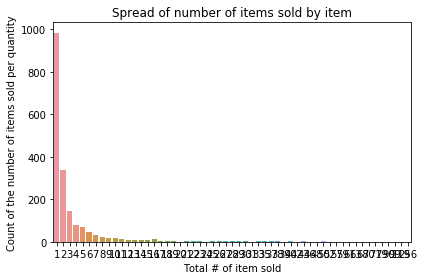

In [9]:
# Find a threshhold below-which it makes sense to drop
sns.countplot(item_count['num_times_sold'])
plt.title('Spread of number of items sold by item')
plt.xlabel('Total # of item sold')
plt.ylabel('Count of the number of items sold per quantity')

plt.tight_layout()
plt.savefig('figures/item_countplot.png')

From the above plot, there are lots of items that only sold once. Those we don't necessarily want, but this doesn't give us any clear "cut off" point. Let's cut off items only sold once at this point.

In [37]:
# Drop items only sold once
item_count = item_count[item_count['num_times_sold']>1]

In [38]:
# Drop 'Rental' and 'Misc Hardware'
item_count.drop(['RENTAL','MISCELLANEOUS HARDWARE'], inplace=True)

### Use that list of items to drop from original data list

In [39]:
# Make a list of the items to keep (the index from item_count)
keep_list = list(item_count.index)

# Use that to filter the data df and keep only those items (description isin list)
data = data[data['description'].isin(keep_list)]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6559 entries, ('1HOLPS', Timestamp('2015-05-08 00:00:00')) to ('4LAKEL', Timestamp('2020-09-30 00:00:00'))
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   qty_shipped         6559 non-null   float64
 1   item                6559 non-null   object 
 2   description         6559 non-null   object 
 3   item_price          6559 non-null   float64
 4   industry            6559 non-null   object 
 5   contact_owner       6559 non-null   object 
 6   lifetime_sales      6559 non-null   float64
 7   first_sale          6559 non-null   object 
 8   county              6559 non-null   object 
 9   market_opportunity  6559 non-null   float64
 10  %_market_opp        6559 non-null   float64
dtypes: float64(5), object(6)
memory usage: 595.4+ KB


### Use this updated list to calculate and rank items by average price

In [40]:
items = data.groupby('description')['item_price'].mean().to_frame()
items.columns = ['avg_sale_price']
items.sort_values('avg_sale_price', ascending=False, inplace=True)

# Create top lists for examination
top_25 = items.head(25)
top_50 = items.head(50)
top_100 = items.head(100)

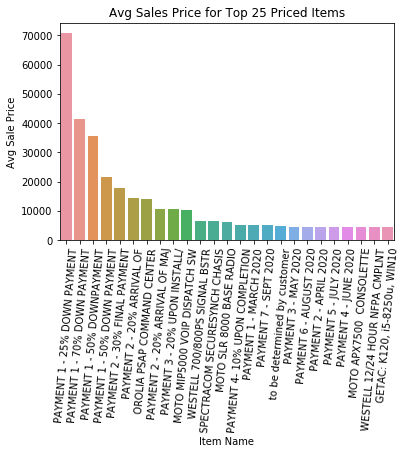

In [14]:
# Plot the top 25 list
sns.barplot(x=top_25.index, y=top_25.avg_sale_price)
plt.title('Avg Sales Price for Top 25 Priced Items')
plt.ylabel('Avg Sale Price')
plt.xticks(rotation=85)
plt.xlabel('Item Name')

plt.savefig('figures/top25_items.png')

#### Drop "Payment" items
These payment items are almost all the highest priced items and throw things off significantly. Drop anything with "payment" in the name"

In [41]:
### Drop any item with "payment" in the name
items.reset_index(inplace=True)

items = items[~items['description'].str.contains('PAYMENT')]
items.set_index('description', inplace=True)
items.head()

# Create top lists for examination
top_25 = items.head(25)
top_50 = items.head(50)

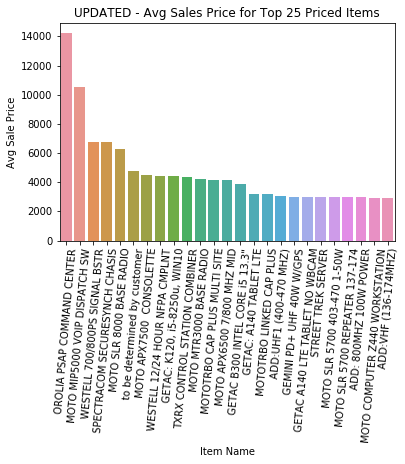

In [16]:
# Plot the top 25 list
sns.barplot(x=top_25.index, y=top_25.avg_sale_price)
plt.title('UPDATED - Avg Sales Price for Top 25 Priced Items')
plt.ylabel('Avg Sale Price')
plt.xticks(rotation=85)
plt.xlabel('Item Name')

plt.savefig('figures/top25_items_no_payment_plans.png')

In [42]:
# Create a new column that is the item rank
items.reset_index(inplace=True)
items['item_price_rank'] = [i+1 for i in items.index]
items.head()

,description,avg_sale_price,item_price_rank
0,OROLIA PSAP COMMAND CENTER,14200.000000,1
1,MOTO MIP5000 VOIP DISPATCH SW,10500.000000,2
2,WESTELL 700/800PS SIGNAL BSTR,6749.500000,3
3,SPECTRACOM SECURESYNCH CHASIS,6743.000000,4
4,MOTO SLR 8000 BASE RADIO,6298.029167,5


#### Drop really low priced items too

How to define "really low?"

In [43]:
items.tail(200)

,description,avg_sale_price,item_price_rank
694,"MOTO 2-WIRE TRANS TUBE, BLACK",39.016667,695
695,"MOTO SURV. EARPIECE, IN-LINE",38.571429,696
696,MOTO COMPACT MICROPHONE W/CLIP,38.400000,697
697,"OPERATOR 1 3/4"" BELT",38.323333,698
698,COMPANY PANT,38.000000,699
...,...,...,...
889,ANDREW 1/4 SUPERFLEX CABLE,1.785714,890
890,LMR400 COAX RG8 CABLE,1.662500,891
891,#6 STRANDED INSUL GRND WIRE,1.433333,892
892,"#6 1 HOLE, 1/4"", SHORT",1.050000,893


The last 200 items are still largely accessories - all priced under $40. That seems like a good enough threshold for now. We can always adjust this later.

In [44]:
# Drop all items priced under $40
items = items[items['avg_sale_price']>40]
items.tail()

,description,avg_sale_price,item_price_rank
672,UNICATION EXTENDED WARRANTY,42.25,673
673,COMPANY CARGO PANT,42.00,674
674,"CABLE, MOBILE MIC EXT",42.00,675
675,N MALE FOR 1/4 FLEX HF-,41.20,676
676,MOTO BATT LIION 2300T,41.00,677


### 4.2.2 Keep only the items left in original dataframe

In [45]:
keep_list = list(items.description.unique())
data = data[data['description'].isin(keep_list)]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5144 entries, ('1HOLPS', Timestamp('2015-05-08 00:00:00')) to ('4MICPD', Timestamp('2020-09-30 00:00:00'))
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   qty_shipped         5144 non-null   float64
 1   item                5144 non-null   object 
 2   description         5144 non-null   object 
 3   item_price          5144 non-null   float64
 4   industry            5144 non-null   object 
 5   contact_owner       5144 non-null   object 
 6   lifetime_sales      5144 non-null   float64
 7   first_sale          5144 non-null   object 
 8   county              5144 non-null   object 
 9   market_opportunity  5144 non-null   float64
 10  %_market_opp        5144 non-null   float64
dtypes: float64(5), object(6)
memory usage: 468.3+ KB


### 4.2.3 Join the item_price_rank with data df


In [46]:
# Join item sales rank with data
data = pd.merge(data.reset_index(), items[['description', 'item_price_rank']], 
                on='description', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5144 entries, 0 to 5143
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer            5144 non-null   object        
 1   invoice_date        5144 non-null   datetime64[ns]
 2   qty_shipped         5144 non-null   float64       
 3   item                5144 non-null   object        
 4   description         5144 non-null   object        
 5   item_price          5144 non-null   float64       
 6   industry            5144 non-null   object        
 7   contact_owner       5144 non-null   object        
 8   lifetime_sales      5144 non-null   float64       
 9   first_sale          5144 non-null   object        
 10  county              5144 non-null   object        
 11  market_opportunity  5144 non-null   float64       
 12  %_market_opp        5144 non-null   float64       
 13  item_price_rank     5144 non-null   int64       

In [47]:
data.head()

,customer,invoice_date,qty_shipped,item,description,item_price,industry,contact_owner,lifetime_sales,first_sale,county,market_opportunity,%_market_opp,item_price_rank
0,1HOLPS,2015-05-08,1.0,T3000,MOTO MTR3000 BASE RADIO,6020.8,K12 Education,Keith Johnson,39760.49,11/01/1999,Ottawa,825673.0,0.309,11
1,1AVOAU,2015-03-31,1.0,T3000,MOTO MTR3000 BASE RADIO,2775.0,Manufacturing,Jessica Spindler,88586.35,9/29/2008,Wexford,67091.0,0.114,11
2,1ZEEFD,2015-08-31,1.0,T3000,MOTO MTR3000 BASE RADIO,6992.0,Fire & EMS,Keith Johnson,37839.27,11/01/1999,Ottawa,825673.0,0.309,11
3,1HILFD,2015-10-30,1.0,T3000,MOTO MTR3000 BASE RADIO,2775.0,Fire & EMS,Jessica Spindler,12403.50,10/30/2013,Montmorency,16068.0,0.222,11
4,1FOURW,2016-03-11,3.0,T3000,MOTO MTR3000 BASE RADIO,2775.0,Hospitality,Tom Gillespie,1123935.02,1/29/2008,Berrien,510290.0,0.291,11


### 4.2.4 Drop all but highest priced item for each sale date

Each row of my final data frame will represent the highest ranked item purchased on that sale date by that customer

In [48]:
# Drop all but the highest priced item for each sale date/customer combo

# Make sure data are sorted by customer, then invoice_date, then item_price descending
data.sort_values(by=['customer','invoice_date','item_price'], ascending=False, inplace=True)

# Drop duplicate (customer/invoice_date) combos, keeping the first (i.e. highest priced)
data.drop_duplicates(subset=['customer','invoice_date'], keep='first', inplace=True)

# Reset index
data.set_index(['customer','invoice_date'], inplace=True)

# Confirm only one item per date per customer
data.sort_index(level='customer')
data.head()

qty_shipped          item  \
customer invoice_date                              
7WOLPO   2017-08-31            4.0  AAH02RDC9VA1   
         2016-06-24            6.0  AAH02RDC9VA1   
7WEYER   2016-09-29            2.0  AAH01QDC9JA2   
         2016-09-20            2.0  AAH01QDC9JA2   
         2016-02-08            1.0  AAH01QDC9JA2   

                                        description  item_price  \
customer invoice_date                                             
7WOLPO   2017-08-31    MOTO XPR3300E 403-512 4W NKP       515.0   
         2016-06-24    MOTO XPR3300E 403-512 4W NKP       515.0   
7WEYER   2016-09-29           MOTO CP200D UHF 4W ND       481.5   
         2016-09-20           MOTO CP200D UHF 4W ND       481.5   
         2016-02-08                CP200D UHF 4W ND       481.5   

                            industry     contact_owner  lifetime_sales  \
customer invoice_date                                                    
7WOLPO   2017-08-31        Utilities  Jessica Spindler       112928.57   
         2016-06-24        Utilities  Jessica Spindler       112928.57   
7WEYER   2016-09-29    Manufacturing  Jessica Spindler         6313.90   
         2016-09-20    Manufacturing  Jessica Spindler         6313.90   
         2016-02-08    Manufacturing  Jessica Spindler         6313.90   

                       first_sale    county  market_opportunity  %_market_opp  \
customer invoice_date                                                           
7WOLPO   2017-08-31    11/01/1999   Wexford             67091.0         0.114   
         2016-06-24    11/01/1999   Wexford             67091.0         0.114   
7WEYER   2016-09-29    11/01/1999  Crawford              5375.0         4.437   
         2016-09-20    11/01/1999  Crawford              5375.0         4.437   
         2016-02-08    11/01/1999  Crawford              5375.0         4.437   

                       item_price_rank  
customer invoice_date                   
7WOLPO   2017-08-31                202  
         2016-06-24                202  
7WEYER   2016-09-29                221  
         2016-09-20                221  
         2016-02-08                236

### 4.2.5 Drop unnessecary columns

Since we only needed the item_price to create this ranking, we can drop that column now. (It would be highly correlated with item_price_rank anyway.

In [49]:
data.drop('item_price',axis=1, inplace=True)

### 4.2.6 Create the Target Feature Column

Now we're ready to create our target feature, which addressing the question: is this the highest priced item purchased by this customer to date?

(Another way of saying, is this the highest ranked item by sales price)

In [69]:
df = data[['item_price_rank']]
df.reset_index(inplace=True)
df.sort_values(['customer','invoice_date'], ascending=[False, True], inplace=True)
df.head()

C:\Users\mdurr\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,customer,invoice_date,item_price_rank
1,7WOLPO,2016-06-24,202
0,7WOLPO,2017-08-31,202
5,7WEYER,2015-06-05,191
4,7WEYER,2016-02-08,236
3,7WEYER,2016-09-20,221


In [75]:
# Loop through the invoice dates for each customer & assign 1 to any purchase ranked higher than
# prior purchases

# this will be the list that becomes target feature
target_list = []

# Loop through each customer
for customer in df.customer.unique():
    cust_df = df[df['customer']==customer]
    
    # counter
    i = 0
    
    for date in cust_df.invoice_date.values:
        # If first item purchased, assign 0
        if i == 0:
            target_list.append(0)
            i += 1
            continue
        
        # For susequent purchases, was this item higher ranked than any previous
        item_max = cust_df.item_price_rank.iloc[:i-1].max()
        
        if cust_df.item_price_rank.iloc[i] > item_max:
            target_list.append(1)
            i += 1
            continue
        else:
            target_list.append(0)
            i += 1
            continue  

C:\Users\mdurr\anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


In [77]:
# double check
target_list[:10]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [79]:
df.head(10)

,customer,invoice_date,item_price_rank
1,7WOLPO,2016-06-24,202
0,7WOLPO,2017-08-31,202
5,7WEYER,2015-06-05,191
4,7WEYER,2016-02-08,236
3,7WEYER,2016-09-20,221
2,7WEYER,2016-09-29,221
6,7WEXSA,2018-09-25,229
8,7WEXCS,2015-10-30,248
7,7WEXCS,2017-09-08,376
10,7WEQUE,2016-05-20,252


In [83]:
# Create target feature
data['target'] = target_list
display(data.info())
display(data.target.value_counts())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1949 entries, ('7WOLPO', Timestamp('2017-08-31 00:00:00')) to ('1ADACO', Timestamp('2015-04-24 00:00:00'))
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   qty_shipped         1949 non-null   float64
 1   item                1949 non-null   object 
 2   description         1949 non-null   object 
 3   industry            1949 non-null   object 
 4   contact_owner       1949 non-null   object 
 5   lifetime_sales      1949 non-null   float64
 6   first_sale          1949 non-null   object 
 7   county              1949 non-null   object 
 8   market_opportunity  1949 non-null   float64
 9   %_market_opp        1949 non-null   float64
 10  item_price_rank     1949 non-null   int64  
 11  target              1949 non-null   int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 196.2+ KB


None

0    1773
1     176
Name: target, dtype: int64

In [84]:
# So we have very imbalanced classes - will upsample our positive target class
data.to_csv('data/processed/data_w_target_feature.csv')

## 4.3 Fix Column Data Types

In [104]:
# For reloaded data df when I screwed up below
data = pd.read_csv('data/processed/data_w_target_feature.csv', 
                   index_col=['customer','invoice_date'])

# In all that engineering we lost our data types
data['industry'] = data['industry'].astype('category')
data['contact_owner'] = data['contact_owner'].astype('category')
data['county'] = data['county'].astype('category')

data['first_sale'] = pd.to_datetime(data['first_sale'])

# Check
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1949 entries, ('7WOLPO', '2017-08-31') to ('1ADACO', '2015-04-24')
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   qty_shipped         1949 non-null   float64       
 1   item                1949 non-null   object        
 2   description         1949 non-null   object        
 3   industry            1949 non-null   category      
 4   contact_owner       1949 non-null   category      
 5   lifetime_sales      1949 non-null   float64       
 6   first_sale          1949 non-null   datetime64[ns]
 7   county              1949 non-null   category      
 8   market_opportunity  1949 non-null   float64       
 9   %_market_opp        1949 non-null   float64       
 10  item_price_rank     1949 non-null   int64         
 11  target              1949 non-null   int64         
dtypes: category(3), datetime64[ns](1), float64(4), int64(2), obje

### 4.3.1 One hot encode Categorical features

In [106]:
data = pd.get_dummies(data.drop(['item','description'], axis=1))
data.head()

qty_shipped  lifetime_sales first_sale  \
customer invoice_date                                           
7WOLPO   2017-08-31            4.0       112928.57 1999-11-01   
         2016-06-24            6.0       112928.57 1999-11-01   
7WEYER   2016-09-29            2.0         6313.90 1999-11-01   
         2016-09-20            2.0         6313.90 1999-11-01   
         2016-02-08            1.0         6313.90 1999-11-01   

                       market_opportunity  %_market_opp  item_price_rank  \
customer invoice_date                                                      
7WOLPO   2017-08-31               67091.0         0.114              202   
         2016-06-24               67091.0         0.114              202   
7WEYER   2016-09-29                5375.0         4.437              221   
         2016-09-20                5375.0         4.437              221   
         2016-02-08                5375.0         4.437              236   

                       target  industry_911 & Dispatch  industry_Agriculture  \
customer invoice_date                                                          
7WOLPO   2017-08-31         0                        0                     0   
         2016-06-24         0                        0                     0   
7WEYER   2016-09-29         0                        0                     0   
         2016-09-20         0                        0                     0   
         2016-02-08         1                        0                     0   

                       industry_Colleges & Universities  ...  county_Muskegon  \
customer invoice_date                                    ...                    
7WOLPO   2017-08-31                                   0  ...                0   
         2016-06-24                                   0  ...                0   
7WEYER   2016-09-29                                   0  ...                0   
         2016-09-20                                   0  ...                0   
         2016-02-08                                   0  ...                0   

                       county_Newaygo  county_Oceana  county_Ogemaw  \
customer invoice_date                                                 
7WOLPO   2017-08-31                 0              0              0   
         2016-06-24                 0              0              0   
7WEYER   2016-09-29                 0              0              0   
         2016-09-20                 0              0              0   
         2016-02-08                 0              0              0   

                       county_Otsego  county_Ottawa  county_Presque Isle  \
customer invoice_date                                                      
7WOLPO   2017-08-31                0              0                    0   
         2016-06-24                0              0                    0   
7WEYER   2016-09-29                0              0                    0   
         2016-09-20                0              0                    0   
         2016-02-08                0              0                    0   

                       county_Roscommon  county_Van Buren  county_Wexford  
customer invoice_date                                                      
7WOLPO   2017-08-31                   0                 0               1  
         2016-06-24                   0                 0               1  
7WEYER   2016-09-29                   0                 0               0  
         2016-09-20                   0                 0               0  
         2016-02-08                   0                 0               0  

[5 rows x 65 columns]

## 4.4 Preprocessing - Scaling, Test/Train split

In [107]:
from sklearn.preprocessing import StandardScaler

# Define X,y
X = data.drop(['target','first_sale'], axis=1)
y = data.target

# Preprocessing
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [108]:
# Split into training/testing sets
from sklearn.model_selection import train_test_split

y = y.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 2)

In [109]:
# Check shapes
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(1949, 63)
(1461, 63)
(488, 63)


# Step 5 - Modelling

Now to build out 3 different models.

## 5.1 - Model 1: Random Forest

Random forest is generally a good base model. It also has the added advantage of giving us feature importance, which can be translated to business impacts

In [110]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model_1 = rfc.fit(X_train, y_train)
y_pred1 = model_1.predict(X_test)

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1, digits=2))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       442
           1       0.22      0.11      0.14        46

    accuracy                           0.88       488
   macro avg       0.56      0.53      0.54       488
weighted avg       0.85      0.88      0.86       488



### 5.1.1 - RFC Feature Importances

For this model, want to see the top features of importance.

In [112]:
# Print feature importances
for name, importance in zip(data.drop(['target','first_sale'], axis=1), 
                            model_1.feature_importances_):
    print(name, ': ', importance)

qty_shipped :  0.19524629093889392
lifetime_sales :  0.17612218959877463
market_opportunity :  0.022267512006978695
%_market_opp :  0.01968567239645363
item_price_rank :  0.39547928239216174
industry_911 & Dispatch :  0.006440947240204678
industry_Agriculture :  0.008847984992169199
industry_Colleges & Universities :  0.002916435117478307
industry_Construction :  0.0037860091719571745
industry_Fire & EMS :  0.012830029069760433
industry_Government Services :  0.00754652706567671
industry_Healthcare :  0.012961472049020603
industry_Hospitality :  0.007553141540658187
industry_K12 Education :  0.010183143795902487
industry_Law Enforcement :  0.01095756642258624
industry_Manufacturing :  0.01126188712443716
industry_Mining & Materials :  0.001871711433935143
industry_Oil & Gas :  5.682814069406747e-05
industry_Property Management :  0.000136822596786241
industry_Religious Institutions :  0.00041575979946379473
industry_Retail :  5.601732283128417e-06
industry_Services & Training :  0.0001

## 5.2 - Model 2:

## 5.3 - Model 3: